In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def lagrange(x: np.ndarray, y: np.ndarray, z: np.ndarray) -> np.ndarray:
    n, m = len(x), len(z)
    w = np.zeros(m)

    for i in range(n):
        p = np.ones(m)
        for j in range(n):
            if i != j:
                p *= (z - x[j]) / (x[i] - x[j])
        w += y[i] * p

    return w


def divided_differences(x: np.ndarray, y: np.ndarray):
    n = len(y)
    table = np.zeros([n, n])
    table[:, 0] = y

    for j in range(1, n):
        for i in range(n - j):
            table[i][j] = (table[i + 1][j - 1] - table[i][j - 1]) / (x[i + j] - x[i])

    return table


def newton_polynomial(coef: np.ndarray, x: np.ndarray, x_new: np.ndarray):
    n = len(x) - 1
    p = coef[n]

    for k in range(1, n + 1):
        p = coef[n - k] + (x_new - x[n - k]) * p
    return p


def newton(x: np.ndarray, y: np.ndarray, x_new: np.ndarray):
    table = divided_differences(x, y)
    return newton_polynomial(table[0], x, x_new)


def select_points(x, y, x_new, degree):
    idx = np.argsort(np.abs(x - x_new))[: degree + 1]
    return x[idx], y[idx]


def natural_cubic_spline(x: np.ndarray, y: np.ndarray):
    n = len(x) - 1
    h = np.diff(x)

    A = np.zeros((n + 1, n + 1))
    A[0, 0], A[n, n] = 1, 1

    for i in range(1, n):
        A[i, i - 1] = h[i - 1]
        A[i, i] = 2 * (h[i - 1] + h[i])
        A[i, i + 1] = h[i]

    b = np.zeros(n + 1)
    for i in range(1, n):
        b[i] = 3 * ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1])

    c = np.linalg.solve(A, b)

    d = np.zeros(n)
    b = np.zeros(n)
    for i in range(n):
        d[i] = (c[i + 1] - c[i]) / (3 * h[i])
        b[i] = (y[i + 1] - y[i]) / h[i] - h[i] * (c[i + 1] + 2 * c[i]) / 3

    def interpolate(x_new: np.ndarray):
        indices = np.clip(np.searchsorted(x, x_new) - 1, 0, n - 1)
        dx = x_new - x[indices]
        return y[indices] + b[indices] * dx + c[indices] * dx**2 + d[indices] * dx**3

    return interpolate

# Exercício 1

Um automóvel percorreu 160 km numa rodovia que liga duas cidades e gastou, neste trajeto, 2 horas e 20 minutos. A tabela abaixo dá o tempo (min) e a distância percorrida (km) em alguns pontos entre as duas cidades.

| Tempo (min) | Distância (km) |
| ----------- | -------------- |
| 0           | 0              |
| 10          | 8              |
| 30          | 27             |
| 60          | 58             |
| 90          | 100            |
| 120         | 145            |
| 140         | 160            |


In [3]:
t = np.array([0, 10, 30, 60, 90, 120, 140])
d = np.array([0, 8, 27, 58, 100, 145, 160])

# a) Qual foi aproximadamente a distância percorrida pelo automóvel no primeiros
# 45 minutos de viagem, considerando apenas os quatro primeiros pontos da tabela?
assert lagrange(t[:4], d[:4], [45]) == [42.5625]
assert newton(t[:4], d[:4], [45]) == [42.5625]
assert natural_cubic_spline(t[:4], d[:4])(45) == 42.37946428571429

# b) Quantos minutos o automóvel gastou para chegar à metade do caminho?
assert np.allclose(lagrange(d, t, [d[-1] / 2]), [77.8354988])
assert np.allclose(newton(d, t, [d[-1] / 2]), [77.8354988])
assert natural_cubic_spline(d, t)(d[-1] / 2) == 77.62193804783054

# Exercício 2

Conhecendo-se o diâmetro e a resistividade de um fio cilíndrico verificou-se a resistência do fio (Ohms) de acordo com o comprimento (m). Os dados obtidos estão indicados a seguir:

| Comprimento (m) | Resistência (Ohms) |
| --------------- | ------------------ |
| 500             | 2,74               |
| 1000            | 5,48               |
| 1500            | 7,90               |
| 2000            | 11,00              |
| 2500            | 13,93              |
| 3000            | 16,43              |
| 3500            | 20,24              |
| 4000            | 23,52              |

Use um polinômio interpolador de grau 2 e um polinômio interpolador de grau 3. para determinar quais serão as prováveis resistências deste fio (Ohms) para comprimentos (m) de:


In [4]:
length = np.array([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
resistance = np.array([2.74, 5.48, 7.90, 11.00, 13.93, 16.43, 20.24, 23.52])

points = [1730, 3200]
results = {}

for degree in [2, 3]:
    results[f"Lagrange (grau {degree})"] = []
    results[f"Newton (grau {degree})"] = []

    for point in points:
        x_selected, y_selected = select_points(length, resistance, point, degree)
        results[f"Lagrange (grau {degree})"].append(lagrange(x_selected, y_selected, np.array([point]))[0])
        results[f"Newton (grau {degree})"].append(newton(x_selected, y_selected, point))

for method, values in results.items():
    for i, point in enumerate(points):
        print(f"{method} para {point} m: {values[i]:.2f} Ohms")

Lagrange (grau 2) para 1730 m: 9.24 Ohms
Lagrange (grau 2) para 3200 m: 17.80 Ohms
Newton (grau 2) para 1730 m: 9.24 Ohms
Newton (grau 2) para 3200 m: 17.80 Ohms
Lagrange (grau 3) para 1730 m: 9.29 Ohms
Lagrange (grau 3) para 3200 m: 17.90 Ohms
Newton (grau 3) para 1730 m: 9.29 Ohms
Newton (grau 3) para 3200 m: 17.90 Ohms


# Exercício 3

Deslocando-se um receptor de GPS num veículo ao longo do eixo de uma estrada, em
Pelotas, obtiveram-se as coordenadas locais:

| latitude (φ) | longitude (λ) |
| ------------ | ------------- |
| 26′56′′      | 5′36′′        |
| 26′50′′      | 5′56′′        |
| 27′02′′      | 6′16′′        |
| 26′58′′      | 6′36′′        |

Aproximando o eixo da estrada por um spline cúbica natural determine:


In [5]:
latitude = np.array([26.56, 26.50, 27.02, 26.58])
longitude = np.array([5.36, 5.56, 6.16, 6.36])

# a) a latitude da estrada quando a longitude é λ = 6′
assert np.allclose(
    natural_cubic_spline(longitude, latitude)([6]),
    [27.04207289],
)

# b) as coordenadas da estrada no ponto mais distante do equador, supondo que
# isso acontece entre 6′16′′ e 6′36′′ de longitude

lon_interp = np.linspace(6.16, 6.36, 100)
lat_interp = natural_cubic_spline(longitude, latitude)(lon_interp)

max_lat_index = np.argmax(lat_interp)


assert np.allclose(
    [lat_interp[max_lat_index], lon_interp[max_lat_index]],
    [27.02, 6.16],
)

# Exercício 4

O número de bactérias, por unidade de volume, existente em uma cultura após x horas é apresentado na tabela:

| numero de horas | numero de bactérias |
| --------------- | ------------------- |
| 0               | 32                  |
| 1               | 47                  |
| 2               | 65                  |
| 3               | 92                  |
| 4               | 132                 |
| 5               | 190                 |
| 6               | 275                 |


In [6]:
hours = np.array([0, 1, 2, 3, 4, 5, 6])
bacteria = np.array([32, 47, 65, 92, 132, 190, 275])

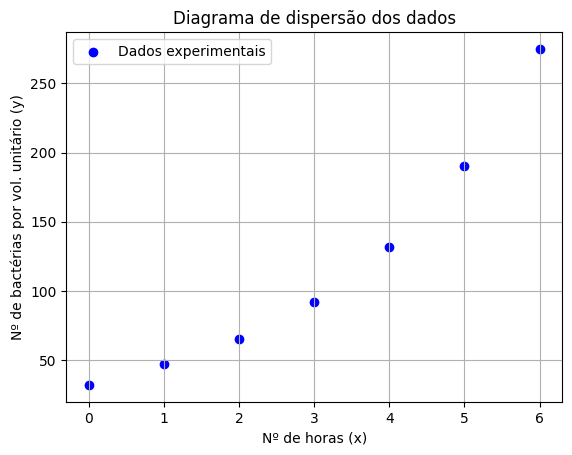

In [7]:
# a) Trace o diagrama de dispersão dos dados
plt.scatter(hours, bacteria, color="blue", label="Dados experimentais")
plt.xlabel("Nº de horas (x)")
plt.ylabel("Nº de bactérias por vol. unitário (y)")
plt.title("Diagrama de dispersão dos dados")
plt.legend()
plt.grid(True)

Previsão para x=7 usando y=ab^x: 393.31 (MSE: 1.14)
Previsão para x=7 usando y=ax^b: 324.85 (MSE: 343.54)


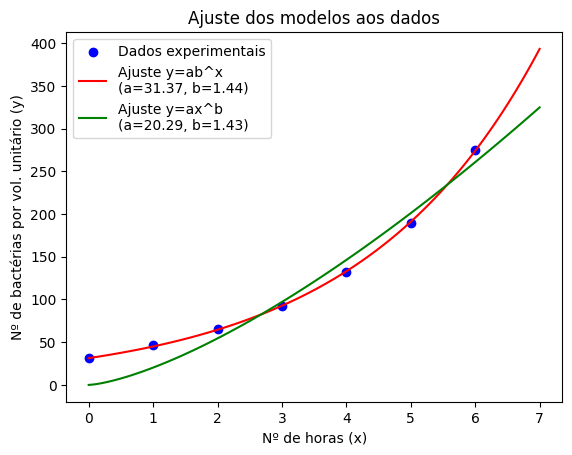

In [8]:
from scipy.optimize import curve_fit

# b) Use o método dos mínimos quadrados para ajustar os dados as curvas y = abx e y = ax


def model_exp(x, a, b):
    return a * b**x


def model_power(x, a, b):
    return a * x**b


x_fit = np.linspace(0, 7, 100)

(a_exp, b_exp), _ = curve_fit(model_exp, hours, bacteria)
y_fit_exp = model_exp(x_fit, a_exp, b_exp)

(a_power, b_power), _ = curve_fit(model_power, hours, bacteria)
y_fit_power = model_power(x_fit, a_power, b_power)


# c) Verifique e justifique qual a equação do melhor ajuste. Utilize ela para
# prever o No de bactérias por vol. unitário (y) em No de horas (x) igual a 7.

y_pred_exp_7 = model_exp(7, a_exp, b_exp)
mse_exp = np.mean((bacteria - model_exp(hours, a_exp, b_exp)) ** 2)
print(f"Previsão para x=7 usando y=ab^x: {y_pred_exp_7:.2f} (MSE: {mse_exp:.2f})")

y_pred_power_7 = model_power(7, a_power, b_power)
mse_power = np.mean((bacteria - model_power(hours, a_power, b_power)) ** 2)
print(f"Previsão para x=7 usando y=ax^b: {y_pred_power_7:.2f} (MSE: {mse_power:.2f})")

# o melhor ajuste é o modelo exponencial, pois possui menor erro quadrático médio
# e prevê um valor mais próximo dos dados experimentais

plt.scatter(hours, bacteria, color="blue", label="Dados experimentais")
plt.plot(x_fit, y_fit_exp, color="red", label=f"Ajuste y=ab^x\n(a={a_exp:.2f}, b={b_exp:.2f})")
plt.plot(x_fit, y_fit_power, color="green", label=f"Ajuste y=ax^b\n(a={a_power:.2f}, b={b_power:.2f})")
plt.xlabel("Nº de horas (x)")
plt.ylabel("Nº de bactérias por vol. unitário (y)")
plt.title("Ajuste dos modelos aos dados")
plt.legend()